In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
PAAD     171
ESCA     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [7]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(111,)

In [8]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [9]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          90
Solid Tissue Normal    80
Name: Sample Type, dtype: int64

Solid Tissue Normal    31
Primary Tumor          26
Name: Sample Type, dtype: int64

In [11]:
train[target].cat.categories

Index(['Primary Tumor', 'Solid Tissue Normal'], dtype='object')

In [12]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [13]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [14]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [15]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.268963
Epoch: 1/10. Train set: Average loss: 109.3384
Epoch: 1/10. Validation set: Average loss: 19.4182
Train: [0/170 (0%)]	Loss: 309.796631
Epoch: 2/10. Train set: Average loss: 128.6826
Epoch: 2/10. Validation set: Average loss: 146.4794
Train: [0/170 (0%)]	Loss: 120.472649
Epoch: 3/10. Train set: Average loss: 220.2393
Epoch: 3/10. Validation set: Average loss: 7.1959
Train: [0/170 (0%)]	Loss: 1.989862
Epoch: 4/10. Train set: Average loss: 13.7897
Epoch: 4/10. Validation set: Average loss: 0.8082
Train: [0/170 (0%)]	Loss: 3.589590
Epoch: 5/10. Train set: Average loss: 3.9411
Epoch: 5/10. Validation set: Average loss: 5.1269
Train: [0/170 (0%)]	Loss: 0.450236
Epoch: 6/10. Train set: Average loss: 8.6736
Epoch: 6/10. Validation set: Average loss: 0.8676
Train: [0/170 (0%)]	Loss: 0.245182
Epoch: 7/10. Train set: Average loss: 1.4281
Epoch: 7/10. Validation set: Average loss: 0.2053
Train: [0/170 (0%)]	Loss: 0.009832
Epoch: 8/10. Train set: Average loss: 0.6

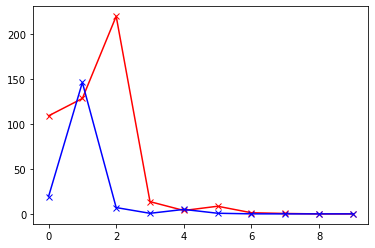

In [16]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

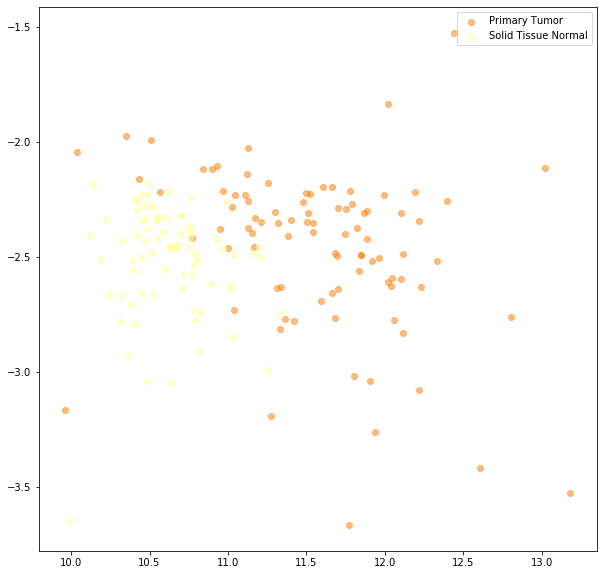

In [17]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

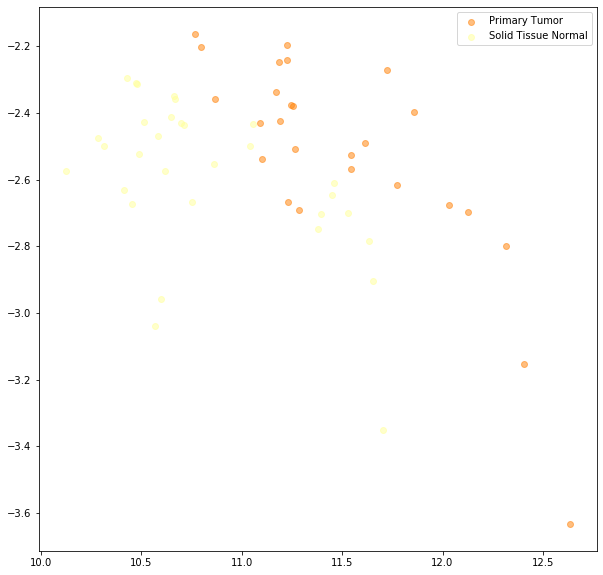

In [18]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

In [19]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [20]:
tmp_model = copy.deepcopy(model)

In [21]:
tmp_model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [22]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

In [23]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [24]:
ig = IntegratedGradients(tmp_model.get_embedding)

In [37]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(28, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c320a54e0>]],
      dtype=object)

,Attribution
count,6.048300e+04
mean,1.309892e-05
std,9.422150e-04
min,-1.274200e-01
25%,-1.380579e-07
50%,3.065761e-08
75%,2.857448e-06
max,3.665242e-02


,Attribution
0,
ENSG00000202198.1,0.036652
ENSG00000198840.2,0.025355
ENSG00000168542.11,0.023917
ENSG00000034510.5,0.022094
ENSG00000108821.12,0.020728
ENSG00000106541.10,0.019849
ENSG00000173432.9,0.019584
ENSG00000111640.13,0.018072
ENSG00000152661.7,0.017361


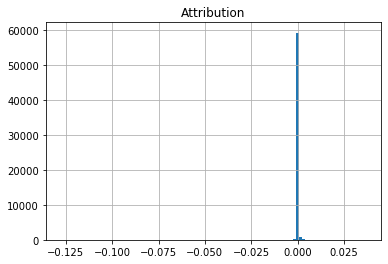

In [38]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

Inspect individual sample attributions

In [41]:
attr_samp = pd.Series(attr[0], index=train_dataset.data.columns)
attr_samp.nlargest(10)
attr_samp.sum()

0
ENSG00000108298.8     0.101187
ENSG00000198938.2     0.088708
ENSG00000002834.16    0.075684
ENSG00000115461.4     0.050550
ENSG00000198899.2     0.037784
ENSG00000125691.11    0.036230
ENSG00000115414.17    0.035006
ENSG00000198712.1     0.034266
ENSG00000074800.12    0.033840
ENSG00000141736.12    0.032823
dtype: float32

0.5839728

In [40]:
for i in range(30):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

0
ENSG00000108298.8     0.101187
ENSG00000198938.2     0.088708
ENSG00000002834.16    0.075684
ENSG00000115461.4     0.050550
ENSG00000198899.2     0.037784
ENSG00000125691.11    0.036230
ENSG00000115414.17    0.035006
ENSG00000198712.1     0.034266
ENSG00000074800.12    0.033840
ENSG00000141736.12    0.032823
dtype: float32

0
ENSG00000108298.8     0.160843
ENSG00000159763.3     0.159224
ENSG00000160180.15    0.156621
ENSG00000106541.10    0.127535
ENSG00000198804.2     0.104087
ENSG00000147676.12    0.095017
ENSG00000086548.8     0.070476
ENSG00000161055.3     0.068009
ENSG00000198938.2     0.065050
ENSG00000160862.11    0.059776
dtype: float32

0
ENSG00000070756.12    0.247847
ENSG00000244468.1     0.066399
ENSG00000034510.5     0.064404
ENSG00000087086.12    0.059444
ENSG00000112306.7     0.045343
ENSG00000184009.8     0.037403
ENSG00000111640.13    0.036898
ENSG00000187840.4     0.036465
ENSG00000272398.4     0.035732
ENSG00000012223.11    0.034220
dtype: float32

0
ENSG00000034510.5     0.064013
ENSG00000106541.10    0.049836
ENSG00000184009.8     0.044363
ENSG00000106211.8     0.034223
ENSG00000255974.5     0.033046
ENSG00000109971.12    0.031498
ENSG00000170421.10    0.030662
ENSG00000080824.17    0.027977
ENSG00000160182.2     0.027582
ENSG00000124214.18    0.025427
dtype: float32

0
ENSG00000111341.8     0.124980
ENSG00000173432.9     0.099816
ENSG00000184009.8     0.052788
ENSG00000111640.13    0.043471
ENSG00000198840.2     0.041877
ENSG00000112306.7     0.037458
ENSG00000227097.5     0.025590
ENSG00000166710.16    0.025241
ENSG00000108821.12    0.024754
ENSG00000034510.5     0.024491
dtype: float32

0
ENSG00000108298.8     0.172155
ENSG00000160180.15    0.155915
ENSG00000159763.3     0.154375
ENSG00000106541.10    0.129038
ENSG00000147676.12    0.098145
ENSG00000160862.11    0.077388
ENSG00000086548.8     0.072316
ENSG00000161055.3     0.065792
ENSG00000111640.13    0.053625
ENSG00000141736.12    0.053522
dtype: float32

0
ENSG00000141424.11    0.102708
ENSG00000198712.1     0.085053
ENSG00000184007.16    0.063635
ENSG00000096384.18    0.044232
ENSG00000198804.2     0.035709
ENSG00000106541.10    0.033092
ENSG00000164125.14    0.028140
ENSG00000197746.12    0.024560
ENSG00000004478.7     0.023661
ENSG00000143742.11    0.020726
dtype: float32

0
ENSG00000152661.7     0.179420
ENSG00000141424.11    0.067467
ENSG00000117984.11    0.064845
ENSG00000115461.4     0.063806
ENSG00000102316.15    0.042955
ENSG00000012223.11    0.041070
ENSG00000160182.2     0.038900
ENSG00000164919.9     0.038255
ENSG00000255974.5     0.031428
ENSG00000173432.9     0.031055
dtype: float32

0
ENSG00000141424.11    0.034643
ENSG00000168542.11    0.031995
ENSG00000108821.12    0.028038
ENSG00000070756.12    0.018281
ENSG00000164692.16    0.017289
ENSG00000133110.13    0.017260
ENSG00000107485.14    0.016390
ENSG00000115414.17    0.016184
ENSG00000012660.12    0.015971
ENSG00000227097.5     0.015968
dtype: float32

0
ENSG00000087086.12    0.082005
ENSG00000204287.12    0.067838
ENSG00000197746.12    0.035801
ENSG00000019582.13    0.035792
ENSG00000166710.16    0.032410
ENSG00000147676.12    0.031516
ENSG00000109062.8     0.030513
ENSG00000163220.10    0.028267
ENSG00000075624.12    0.027772
ENSG00000198840.2     0.027329
dtype: float32

0
ENSG00000168542.11    0.067382
ENSG00000113140.9     0.048947
ENSG00000108821.12    0.046122
ENSG00000164692.16    0.039382
ENSG00000133110.13    0.032289
ENSG00000115414.17    0.028284
ENSG00000198804.2     0.024972
ENSG00000131171.11    0.024380
ENSG00000244468.1     0.021715
ENSG00000139329.4     0.020562
dtype: float32

0
ENSG00000111640.13    0.113039
ENSG00000173432.9     0.088986
ENSG00000112306.7     0.085739
ENSG00000075624.12    0.048552
ENSG00000034510.5     0.041467
ENSG00000179218.12    0.038220
ENSG00000005022.5     0.038033
ENSG00000110955.7     0.037989
ENSG00000184009.8     0.036059
ENSG00000111341.8     0.035517
dtype: float32

0
ENSG00000202198.1    1.027057
ENSG00000211459.2    0.446162
ENSG00000274012.1    0.196142
ENSG00000251562.6    0.168207
ENSG00000164128.5    0.107781
ENSG00000252621.1    0.063136
ENSG00000225972.1    0.038372
ENSG00000173432.9    0.037337
ENSG00000256612.6    0.036636
ENSG00000245532.5    0.024770
dtype: float32

0
ENSG00000168542.11    0.041597
ENSG00000106541.10    0.035364
ENSG00000173432.9     0.034243
ENSG00000108821.12    0.031255
ENSG00000198695.2     0.029847
ENSG00000133110.13    0.027266
ENSG00000184009.8     0.026720
ENSG00000198840.2     0.025553
ENSG00000111640.13    0.023182
ENSG00000102316.15    0.019768
dtype: float32

0
ENSG00000184009.8     0.072352
ENSG00000034510.5     0.059936
ENSG00000106541.10    0.053082
ENSG00000111341.8     0.038561
ENSG00000170421.10    0.036723
ENSG00000109971.12    0.036598
ENSG00000096384.18    0.035623
ENSG00000080824.17    0.035023
ENSG00000198840.2     0.034587
ENSG00000255974.5     0.032421
dtype: float32

0
ENSG00000168542.11    0.068727
ENSG00000113140.9     0.052696
ENSG00000108821.12    0.047693
ENSG00000164692.16    0.041120
ENSG00000124935.3     0.035123
ENSG00000133110.13    0.031071
ENSG00000244468.1     0.030938
ENSG00000115414.17    0.029286
ENSG00000124107.5     0.026267
ENSG00000102316.15    0.024539
dtype: float32

0
ENSG00000268751.1     0.185448
ENSG00000096384.18    0.101100
ENSG00000223648.3     0.068594
ENSG00000070756.12    0.062387
ENSG00000198840.2     0.058486
ENSG00000204287.12    0.051432
ENSG00000211659.2     0.046052
ENSG00000166710.16    0.043152
ENSG00000075624.12    0.040012
ENSG00000211662.2     0.039852
dtype: float32

0
ENSG00000211662.2     0.169574
ENSG00000198840.2     0.167438
ENSG00000163220.10    0.107102
ENSG00000034510.5     0.066382
ENSG00000117984.11    0.038060
ENSG00000105193.7     0.029985
ENSG00000110484.6     0.029933
ENSG00000118785.12    0.028956
ENSG00000198695.2     0.028537
ENSG00000065978.16    0.027488
dtype: float32

0
ENSG00000087086.12    0.086903
ENSG00000166710.16    0.075819
ENSG00000204287.12    0.050163
ENSG00000205542.9     0.045141
ENSG00000034510.5     0.041324
ENSG00000272398.4     0.034704
ENSG00000075624.12    0.034546
ENSG00000118785.12    0.028906
ENSG00000197746.12    0.028394
ENSG00000278196.1     0.019641
dtype: float32

0
ENSG00000111341.8     0.112631
ENSG00000184009.8     0.048863
ENSG00000111640.13    0.042175
ENSG00000112306.7     0.038945
ENSG00000108821.12    0.026134
ENSG00000198840.2     0.024622
ENSG00000096384.18    0.022771
ENSG00000227097.5     0.022113
ENSG00000034510.5     0.021688
ENSG00000075624.12    0.021290
dtype: float32

0
ENSG00000168542.11    0.066211
ENSG00000113140.9     0.045849
ENSG00000108821.12    0.045844
ENSG00000164692.16    0.037750
ENSG00000198938.2     0.036771
ENSG00000133110.13    0.032224
ENSG00000244468.1     0.030937
ENSG00000128422.14    0.030587
ENSG00000115414.17    0.028316
ENSG00000198804.2     0.027800
dtype: float32

0
ENSG00000263639.4     0.229414
ENSG00000168542.11    0.067770
ENSG00000108821.12    0.046507
ENSG00000099194.5     0.041586
ENSG00000109062.8     0.034308
ENSG00000164692.16    0.031948
ENSG00000184009.8     0.031534
ENSG00000141424.11    0.031319
ENSG00000110092.3     0.030262
ENSG00000117984.11    0.029855
dtype: float32

0
ENSG00000087086.12    0.090560
ENSG00000166710.16    0.075884
ENSG00000204287.12    0.048944
ENSG00000272398.4     0.034136
ENSG00000205542.9     0.033230
ENSG00000198712.1     0.032914
ENSG00000198804.2     0.031903
ENSG00000034510.5     0.031796
ENSG00000118785.12    0.027628
ENSG00000132465.9     0.024066
dtype: float32

0
ENSG00000152661.7     0.179384
ENSG00000141424.11    0.075336
ENSG00000117984.11    0.061024
ENSG00000012223.11    0.052749
ENSG00000115461.4     0.050074
ENSG00000102316.15    0.048588
ENSG00000160182.2     0.042347
ENSG00000164919.9     0.037652
ENSG00000198840.2     0.035485
ENSG00000160862.11    0.030995
dtype: float32

0
ENSG00000263639.4     0.229508
ENSG00000168542.11    0.068945
ENSG00000108821.12    0.046777
ENSG00000184009.8     0.036069
ENSG00000099194.5     0.035888
ENSG00000109062.8     0.035242
ENSG00000141424.11    0.032597
ENSG00000164692.16    0.031608
ENSG00000169710.6     0.028797
ENSG00000117984.11    0.027058
dtype: float32

0
ENSG00000106541.10    0.052843
ENSG00000034510.5     0.047096
ENSG00000184009.8     0.040680
ENSG00000211592.5     0.036241
ENSG00000170421.10    0.035478
ENSG00000255974.5     0.032988
ENSG00000106211.8     0.032829
ENSG00000160182.2     0.028704
ENSG00000111057.9     0.026736
ENSG00000124214.18    0.025872
dtype: float32

0
ENSG00000198840.2     0.065134
ENSG00000168542.11    0.045658
ENSG00000106541.10    0.036191
ENSG00000184009.8     0.034860
ENSG00000108821.12    0.034642
ENSG00000111640.13    0.029747
ENSG00000133110.13    0.028470
ENSG00000075624.12    0.028301
ENSG00000034510.5     0.023484
ENSG00000198695.2     0.022966
dtype: float32

0
ENSG00000204287.12    0.112834
ENSG00000166710.16    0.074328
ENSG00000019582.13    0.049547
ENSG00000173432.9     0.038461
ENSG00000211658.2     0.028697
ENSG00000090382.5     0.020458
ENSG00000152661.7     0.015353
ENSG00000211659.2     0.014166
ENSG00000198840.2     0.013863
ENSG00000177954.10    0.012910
dtype: float32

IndexError: index 28 is out of bounds for axis 0 with size 28

#### Check embedding of zero-feature vector

In [45]:
base_zero = torch.zeros(siamese_test_dataset.test_data.shape[1]).cuda()
base_emb = model.get_embedding(base_zero)
base_emb

tensor([0.1497, 0.1312], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
model.get_l